# Modeling of void fraction in fluid channel

This notebook is designed for analysis of neutron data
which describes void fraction of refrigerant
flowing through a microfluidic channel.

Created on Thu Feb 13 10:33:13 2020  
author: ericmuckley@gmail.com

In [1]:
import os
import cv2
import numpy as np
from glob import glob
from time import time
import matplotlib.pyplot as plt

# change matplotlib settings to make plots look nicer
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.minor.width'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.minor.width'] = 3
plt.rcParams['ytick.major.width'] = 3

def plot_setup(labels=['X', 'Y'], fsize=18, title='', size=None):
    """Creates a custom plot configuration to make graphs look nice.
    This should be called between plt.plot() and plt.show() commands."""
    plt.xlabel(str(labels[0]), fontsize=fsize)
    plt.ylabel(str(labels[1]), fontsize=fsize)
    plt.title(title, fontsize=fsize)

def plot_channel_image(image, title=None, vmin=None, vmax=None):
    """Plot image of the channel, colored by void fraction."""
    plt.imshow(image, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, )
    fig = plt.gcf()
    fig.set_size_inches(11,11)
    plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=16)
    plt.show()

## Get image list

Get list of all images which we will model.

In [2]:
# set path of folder which contains image files
folder_path = os.path.join(os.getcwd(), 'data')

# get list of all '.tif' files in data folder
all_images = [f for f in glob(folder_path+'/*') if '.tif' in f]
print('Found {} images:'.format(len(all_images)))
for img in all_images:
    print(os.path.split(img)[1])

# look at only 75 lb flow rate images for now
all_images = sorted([i for i in all_images if '75' in i])

Found 17 images:
25lbhA0010.tif
25lbhA0020.tif
25lbhA0030.tif
25lbhA0040.tif
25lbhA0050.tif
25lbhA0060.tif
25lbhA0070.tif
75lbh000010.tif
75lbh000020.tif
75lbh000030.tif
75lbh000040.tif
75lbh000050.tif
75lbh000060.tif
75lbh000070.tif
75lbh000080.tif
75lbh000090.tif
75lbh000100.tif


## Set parameters of the model

Here we define the physical dimensions of the channel
(width, height, depth) in μm, bubble radii limits,
minimum fluid buffer size between bubbles,
the maximum number of bubbles to add to the simulation,
the numner of micrometers per pixel we want for the scale
of the cropped images, and an empty dictionary to hold
each cropped channel image.

We save all this information to file so it can be
imported and parsed later.

**Physical dimensions of the channel**
* Height (y-direction) is 750 um
* Length (x-direction) is 20000 um
* Depth (z-direction) is 250 um (for each of 20 channels)
* Aspect ratio (length / height) = 20000 / 750 = 27
* Image resolution is approximately 50 um per pixel

In [3]:
model_info = {
    'w_um': 20000,
    'h_um': 750,
    'd_um': 250,
    'um_per_pixel': 20,
    'buffer_um': 0.1,
    'min_rad_um': 5,
    'max_rad_um': 250, 
    'num_of_bubbles_to_try': 250000,
    'channels': {}}

## Trim and scale channel images

Here we remove the aluminum region around the channel in each
image so that the channel region is isolated.
The channel region is marked by white lines in the plots below.
After non-channel regions are cropped away, the void faction
of each channel is calculated so that blue=0 and red=1.
Finally, we save all the cropped images to file in a single dictionary
so they can be easily imported later.

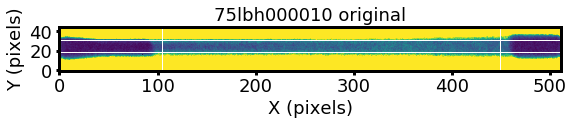

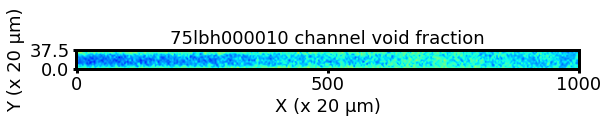

New image pixel shape: (1000, 37)
Aspect ratio of channel image: 27.0
Average void fraction: 34.88%


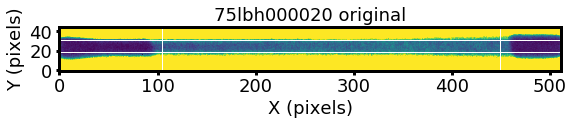

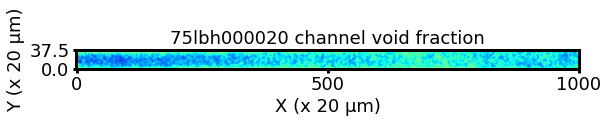

New image pixel shape: (1000, 37)
Aspect ratio of channel image: 27.0
Average void fraction: 35.47%


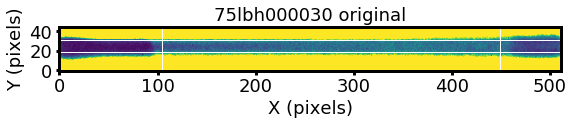

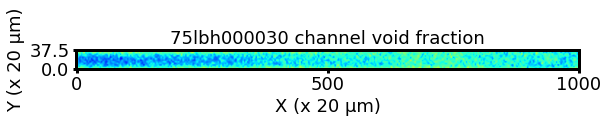

New image pixel shape: (1000, 37)
Aspect ratio of channel image: 27.0
Average void fraction: 37.32%


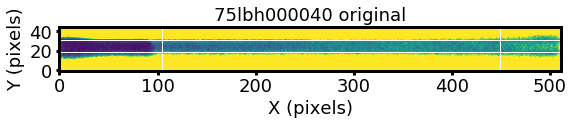

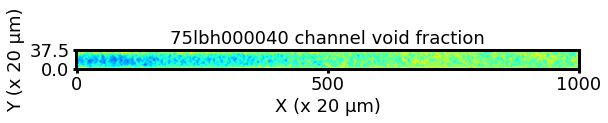

New image pixel shape: (1000, 37)
Aspect ratio of channel image: 27.0
Average void fraction: 45.36%


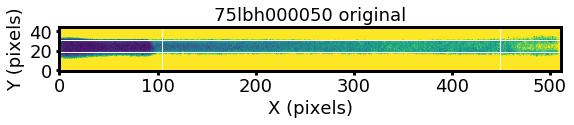

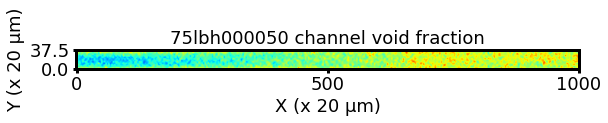

New image pixel shape: (1000, 37)
Aspect ratio of channel image: 27.0
Average void fraction: 51.15%


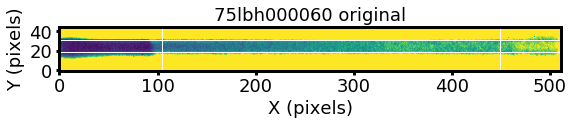

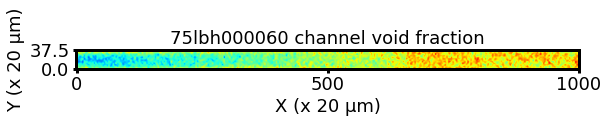

New image pixel shape: (1000, 37)
Aspect ratio of channel image: 27.0
Average void fraction: 54.3%


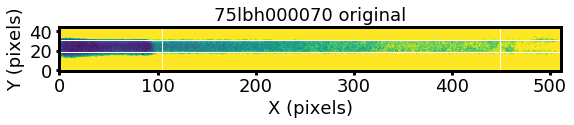

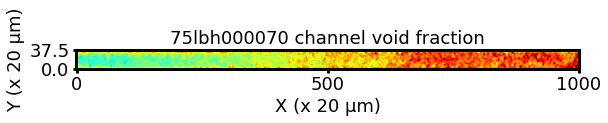

New image pixel shape: (1000, 37)
Aspect ratio of channel image: 27.0
Average void fraction: 65.95%


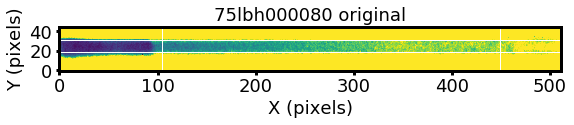

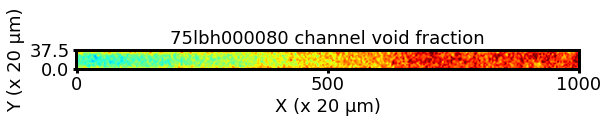

New image pixel shape: (1000, 37)
Aspect ratio of channel image: 27.0
Average void fraction: 68.03%


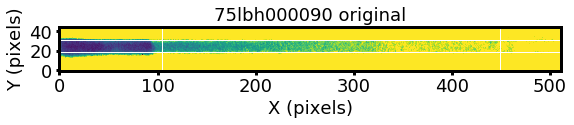

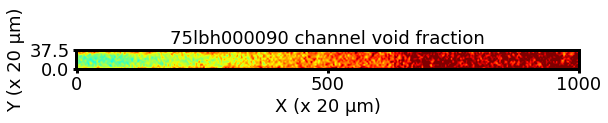

New image pixel shape: (1000, 37)
Aspect ratio of channel image: 27.0
Average void fraction: 76.78%


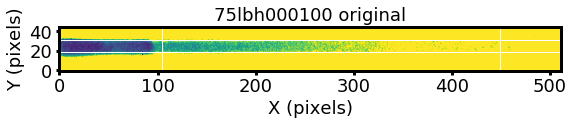

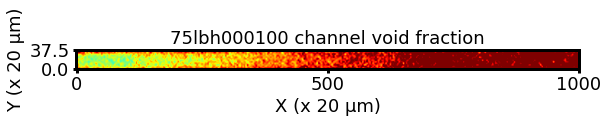

New image pixel shape: (1000, 37)
Aspect ratio of channel image: 27.0
Average void fraction: 82.91%


In [4]:
# loop over each image and trim image to channel dimensions
for img in all_images:
    
    # get flowrate and temperature from image names
    label = os.path.split(img)[1].split('.')[0]
    flowrate = int(label.split('lb')[0])

    # trim image based on the flow rate so that all images are centered
    if flowrate == 25:
        img_raw = plt.imread(img)[:, :, 0].T[245:280]
        temp = int(label.split('00')[-1])
        xlims, ylims = [76, 420], [14, 26]
    if flowrate == 75:
        img_raw = plt.imread(img)[:, :, 0].T[225:270]
        temp = int(label.split('000')[-1])
        xlims, ylims = [105, 449], [19, 31]
        
    # cut image to only include channel interior
    img_channel = img_raw[ylims[0]:ylims[1], xlims[0]:xlims[1]]
    
    # rescale image using user-specified 'um per pixel' scale
    img_channel = cv2.resize(
        img_channel,
        dsize=(int(model_info['w_um']/model_info['um_per_pixel']),
               int(model_info['h_um']/model_info['um_per_pixel'])),
        interpolation=cv2.INTER_CUBIC)
    
    # save channel results into dictionary
    model_info['channels'][label] = {
            'flowrate': flowrate,
            'temp': temp,
            'img_raw': img_raw,
            'img_channel': img_channel,
            'img_voidfrac': img_channel/255*model_info['d_um']} 

    # plot original channel image with channel bounding lines
    [plt.axvline(x=L, color='w', lw=1) for L in xlims]
    [plt.axhline(y=L, color='w', lw=1) for L in ylims]
    plt.imshow(img_raw, origin='lower', vmin=0, vmax=255)
    plot_setup(title=label+' original', labels=['X (pixels)', 'Y (pixels)'])
    plt.yticks([0, 20, 40])
    fig = plt.gcf()
    fig.set_size_inches(9, 9)
    plt.show()
    
    # plot cropped channel image
    plt.imshow(img_channel, origin='lower',
               vmin=0, vmax=model_info['d_um'], cmap='jet')
    plot_setup(title=label+' channel void fraction',
               labels=['X (x '+str(int(model_info['um_per_pixel']))+' μm)',
                       'Y (x '+str(int(model_info['um_per_pixel']))+' μm)'])
    plt.xticks([0,
                int(model_info['w_um']/model_info['um_per_pixel']/2),
                model_info['w_um']/model_info['um_per_pixel']])
    plt.yticks([0, model_info['h_um']/model_info['um_per_pixel']])
    fig = plt.gcf()
    fig.set_size_inches(9, 9)
    #plt.colorbar(fraction=0.02, pad=0.04)
    plt.show()
    
    print('New image pixel shape: {}'.format(img_channel.shape[::-1]))
    print('Aspect ratio of channel image: {}'.format(
        round(img_channel.shape[1]/img_channel.shape[0], 1)))
    print('Average void fraction: {}%'.format(
        round(100*np.mean(
            model_info['channels'][label]['img_voidfrac']/model_info['d_um']), 2)))
    print('======================================================================')

# save model parameters and cropped images to file
model_info_path = os.path.join(os.getcwd(), 'model_info.npy')
np.save(model_info_path, model_info)

## Model the void fraction in each channel image

Now we use Monte Carlo methods to construct possible bubble configurations
in the channel which will approximate the experimentally-measured
void fraction in each image. This is carried out by beginning
with a uniform simulated channel of void fraction = 0 and incrementally
adding bubbles of stochastic positions and radii until the
void fraction in the modeled channel is equal to the void fraction
in the measured image within an error threshold.

First we import the trimmed channel images from the dictionary file.
Then we loop over each image, construct an empty simulated channel, and
incrementally add bubbles to it. When the simulated channel matches the
image, we stop and move to the next image.

THe simulated channel models are saved to file in the *\models* directory.
Each model is saved as a Python dictionary and corresponds
to a particular channel image. The model includes:
* **label**: (filename) of the original channel image
* **img_model**: simulated channel image
* **img_voidfrac**: measured void fraction image
* **cent**: the centers of the simulated bubbles, in ordered pairs (x, y)
* **rad**: the radii of the simulated bubbles
* **percent_error**: total percent error between the measured channel image and the simulated channel image

In [5]:
def get_channel(channel_shape):
    """Return list of all index coordinates of the empty channel."""
    # get list of ordered pairs of channel index coordinates
    yy_channel, xx_channel = np.indices(channel_shape)
    channel_coords = np.column_stack(
        (np.ravel(xx_channel), np.ravel(yy_channel)))
    return channel_coords

def get_bubbles(model_info, channel):
    """Get random bubble radii and center coordinates."""
    # get number of bubbles and radii limits
    num = model_info['num_of_bubbles_to_try']
    min_rad = model_info['min_rad_um']/model_info['um_per_pixel'],
    max_rad = model_info['max_rad_um']/model_info['um_per_pixel']
    # get random radii and sort from large to small
    rad_list = np.random.uniform(min_rad, max_rad, num)
    rad_list = np.clip(rad_list, min_rad, max_rad)
    rad_list = np.sort(rad_list)[::-1]
    # get random x- and y-positions within the channel
    x_list = np.random.uniform(0, len(channel[0]), num)
    y_list = np.random.uniform(0, len(channel), num)
    return {
        'rad': rad_list,
        'rad_squared': np.square(rad_list),
        'x': x_list,
        'y': y_list}

C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt


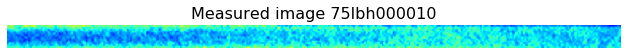

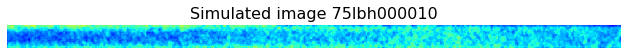

bubbles in channel: 22016
total runtime (min): 3.6
simulation error (%): 3.9
--------------------------------------------------------------



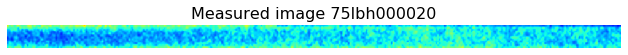

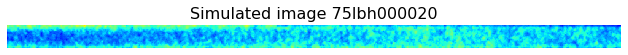

bubbles in channel: 21876
total runtime (min): 7.2
simulation error (%): 3.9
--------------------------------------------------------------



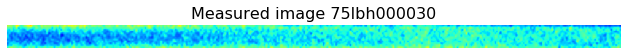

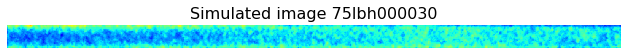

bubbles in channel: 22206
total runtime (min): 10.9
simulation error (%): 3.75
--------------------------------------------------------------



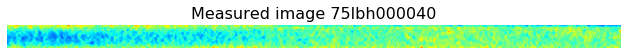

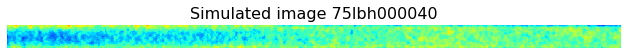

bubbles in channel: 23170
total runtime (min): 14.6
simulation error (%): 3.38
--------------------------------------------------------------



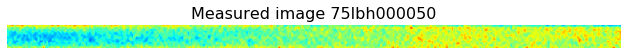

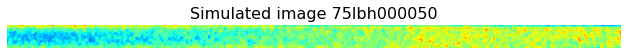

bubbles in channel: 23795
total runtime (min): 18.4
simulation error (%): 3.2
--------------------------------------------------------------



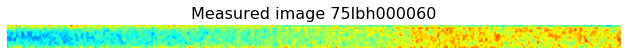

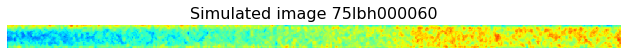

bubbles in channel: 24103
total runtime (min): 22.1
simulation error (%): 3.15
--------------------------------------------------------------



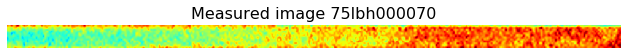

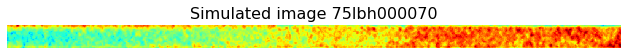

bubbles in channel: 25289
total runtime (min): 26.2
simulation error (%): 2.96
--------------------------------------------------------------



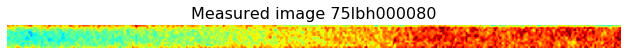

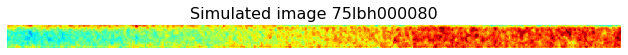

bubbles in channel: 25344
total runtime (min): 30.3
simulation error (%): 2.87
--------------------------------------------------------------



In [ ]:
starttime = time()

# loop over each image
for L in list(model_info['channels']):

    # get target image to model
    measured_image = model_info['channels'][L]['img_voidfrac']

    # get list of channel index coordinates and potential bubbles
    channel_coords = get_channel(measured_image.shape)
    bub_dict = get_bubbles(model_info, measured_image)

    # simulate empty channel to populate with simulated bubbles
    sim = {
        'label': L,
        'flowrate': model_info['channels'][L]['flowrate'],
        'temp': model_info['channels'][L]['temp'],
        'img_model': np.zeros_like(measured_image),
        'img_voidfrac': measured_image,
        'cent': [],
        'rad': []}
    
    # pixels to add to each bubble as a fluid buffer
    buffer_pixels = model_info['buffer_um']/model_info['um_per_pixel']
    
    # loop over each bubble to try and fit into the channel
    for i in range(len(bub_dict['rad'])):

        # get z-profile of new bubble
        bub_profile = 2*np.sqrt(bub_dict['rad_squared'][i]
                                - np.square(channel_coords[:, 0]-bub_dict['x'][i])
                                - np.square(channel_coords[:, 1]-bub_dict['y'][i])) + buffer_pixels


        # convert nan to 0 and reshape to channel size
        bub_profile = np.where(np.isnan(bub_profile),
                               0, bub_profile).reshape(sim['img_model'].shape)


        # add new bubble to channel if it will fit
        if np.all(sim['img_model'] + bub_profile <= 1.02*sim['img_voidfrac']):
            sim['img_model'] += bub_profile
            sim['rad'].append(bub_dict['rad'][i])
            sim['cent'].append([bub_dict['x'][i], bub_dict['y'][i]])


    # get total avg error between image and model
    tot_err = np.mean(np.abs((sim['img_model']-sim['img_voidfrac'])/sim['img_voidfrac']))*100
    sim['percent_error'] = round(tot_err, 2)
    
    # save model to file on local machine
    save_model_path = os.path.join(os.getcwd(), 'models', L + '__model.npy')
    np.save(save_model_path, sim)
    
    # show original channel image
    plot_channel_image(sim['img_voidfrac'], title='Measured image '+L,
                       vmin=0, vmax=model_info['d_um'])
    plt.show()

    # show simulated channel image
    plot_channel_image(sim['img_model'], title='Simulated image '+L,
                       vmin=0, vmax=model_info['d_um'])
    plt.show()

    # print statistics of model
    print('bubbles in channel: {}'.format(len(sim['rad'])))
    print('total runtime (min): {}'.format(round((time() - starttime)/60,1)))
    print('simulation error (%): {}'.format(round(tot_err, 2)))
    print('--------------------------------------------------------------\n')